In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer, Attention, Reshape, Multiply, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import seaborn as sns
from scipy.stats import mode
import os
from itertools import product
import joblib
from scipy.stats import pearsonr
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.layers import Attention, Input, Concatenate

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create 'Tamil, Malayalam' directory if it doesn't exist
os.makedirs('Tamil', exist_ok=True)
os.makedirs('Malayalam', exist_ok=True)

trn_test_split = 0.3
val_test_split = 0.7

def create_dnn_model(input_shape, num_classes):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(4, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model
    
def preprocess_input(X, scaler):
    return scaler.transform(X)

def ensemble_predict_weights(X_mt5, X_roberta, X_indic, X_sentence, weights):
    # Scale inputs for each model
    X_mt5 = preprocess_input(X_mt5, scaler_mt5)
    X_roberta = preprocess_input(X_roberta, scaler_roberta)
    X_indic = preprocess_input(X_indic, scaler_indic)
    X_sentence = preprocess_input(X_sentence, scaler_sentence)

    # Get predictions (probabilities) from each model
    pred_mt5 = model_mt5.predict(X_mt5, verbose=0)
    pred_roberta = model_roberta.predict(X_roberta, verbose=0)
    pred_indic = model_indic.predict(X_indic, verbose=0)
    pred_sentence = model_sentence.predict(X_sentence, verbose=0)

    # Flatten the predictions to convert them to 1D arrays (if needed)
    pred_mt5_flat = np.argmax(pred_mt5, axis=1)  # Convert to predicted class indices
    pred_roberta_flat = np.argmax(pred_roberta, axis=1)
    pred_indic_flat = np.argmax(pred_indic, axis=1)
    pred_sentence_flat = np.argmax(pred_sentence, axis=1)
    
    # # Create a matrix of predictions
    # pred_matrix = np.vstack([pred_mt5_flat, pred_roberta_flat, pred_indic_flat, pred_sentence_flat])
    
    # # Compute the correlation matrix
    # correlation_matrix = np.corrcoef(pred_matrix)
    
    # # Plot the heatmap
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['MT5', 'Roberta', 'Indic', 'Sentence'], yticklabels=['MT5', 'Roberta', 'Indic', 'Sentence'])
    # plt.title("Correlation Matrix of Model Predictions")
    # plt.show()

    # Combine predictions using weighted average
    combined_preds = (
        weights[0] * pred_mt5 +
        weights[1] * pred_roberta +
        weights[2] * pred_indic +
        weights[3] * pred_sentence
    )


    # Convert weighted probabilities to class predictions
    final_preds = np.argmax(combined_preds, axis=1)

    return final_preds

## Tamil

In [3]:
data_sentence = pd.read_csv('/kaggle/input/naacl-human-ai-features-embeddings/MT5/tam_training_data_hum_ai_mt5_embeddings.csv')
language = 'Tamil'

label_encoder = LabelEncoder()
label_encoder.fit(data_sentence['LABEL'])

# split the data_sentence into train, validation and test
train_df, test_df = train_test_split(data_sentence, test_size=trn_test_split, stratify=data_sentence['LABEL'], shuffle=True, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=val_test_split,stratify=test_df['LABEL'], shuffle=True, random_state=42)

train_ID = train_df['ID']
val_ID = val_df['ID']
test_ID = test_df['ID']

paths =['/kaggle/input/naacl-human-ai-features-embeddings/MT5/tam_training_data_hum_ai_mt5_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/XLM/tam_training_data_hum_ai_roberta_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/indic/tam_training_data_hum_ai_indicbert_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/sentence/tam_training_data_hum_ai_sentence_embeddings.csv']

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 810,398 (3.09 MB)

 Trainable params: 807,838 (3.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

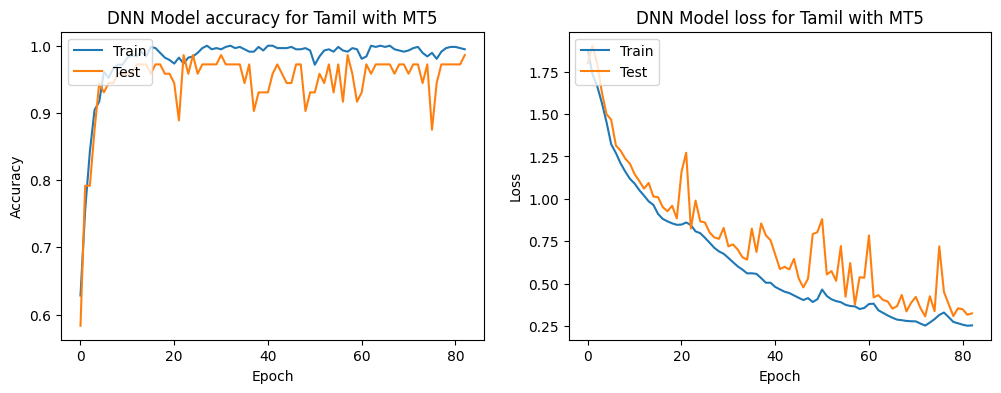

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
DNN For Tamil with MT5:
Accuracy: 0.9532163742690059

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        86
           1       0.98      0.93      0.95        85

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



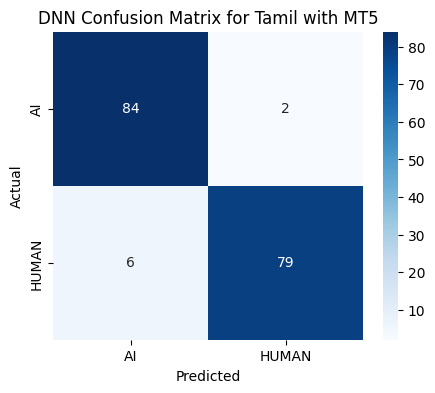

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 1024)                │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,542 (4.09 MB)

 Trainable params: 1,069,982 (4.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

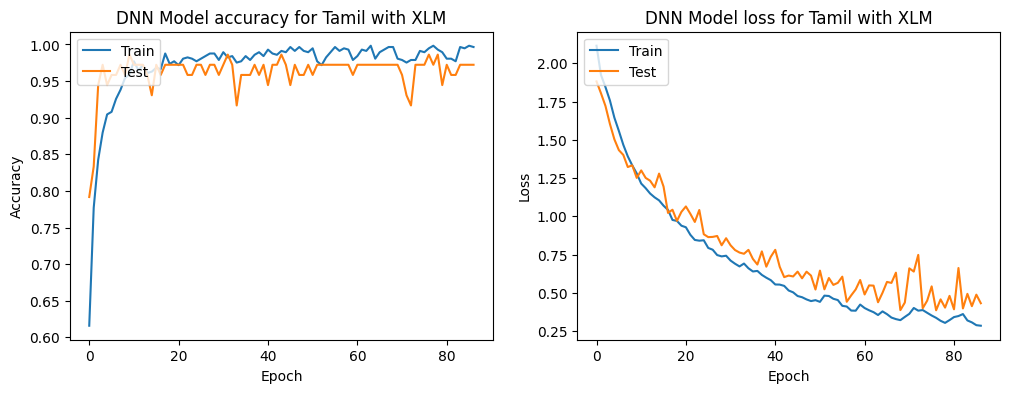

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
DNN For Tamil with XLM:
Accuracy: 0.9707602339181286

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        86
           1       1.00      0.94      0.97        85

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



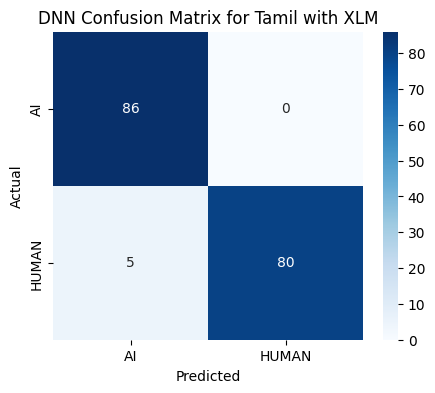

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 1024)                │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,542 (4.09 MB)

 Trainable params: 1,069,982 (4.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

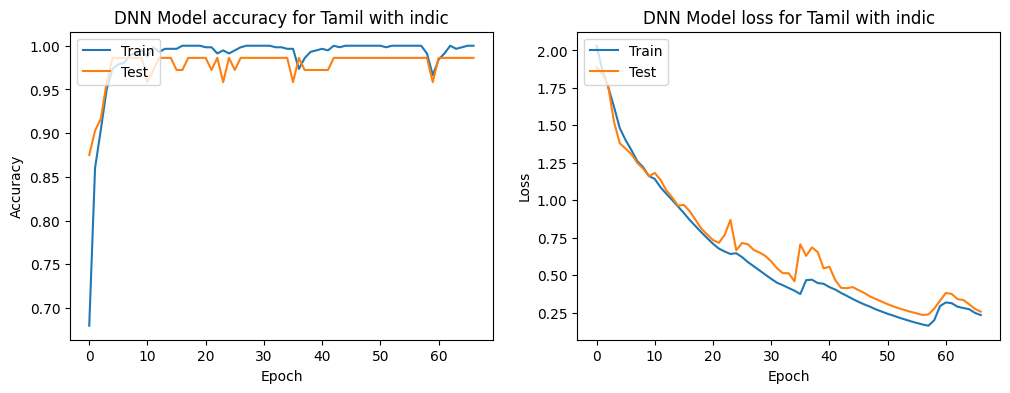

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
DNN For Tamil with indic:
Accuracy: 0.9707602339181286

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        86
           1       1.00      0.94      0.97        85

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



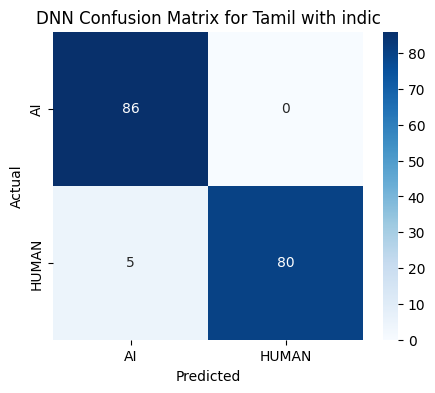

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 810,398 (3.09 MB)

 Trainable params: 807,838 (3.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

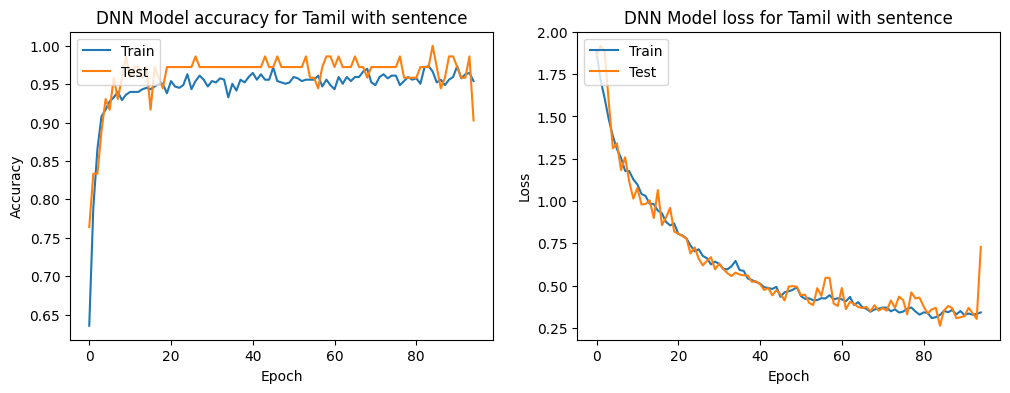

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
DNN For Tamil with sentence:
Accuracy: 0.9590643274853801

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        86
           1       0.96      0.95      0.96        85

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



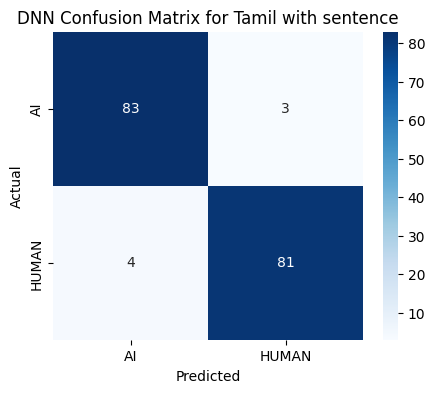

In [4]:
test = []
X_weights = []

for index, path in enumerate(paths):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    name = path.split('/')[-2]
    data_sentence = pd.read_csv(path)
    train_data_sentence = data_sentence[data_sentence['ID'].isin(train_ID)]
    val_data_sentence = data_sentence[data_sentence['ID'].isin(val_ID)]
    test_data_sentence = data_sentence[data_sentence['ID'].isin(test_ID)]
    train_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)
    val_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)
    test_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)

    input_shape = (train_data_sentence.shape[1] - 1,)
    num_classes = 2

    # Specify the learning rate
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)

    model = create_dnn_model(input_shape, num_classes)
   
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Display the model's architecture
    model.summary()

    X_train = train_data_sentence.drop(columns=['LABEL'], axis=1)
    y_train = train_data_sentence['LABEL']

    X_val = val_data_sentence.drop(columns=['LABEL'], axis=1)
    y_val = val_data_sentence['LABEL']

    X_test = test_data_sentence.drop(columns=['LABEL'], axis=1)
    y_test = test_data_sentence['LABEL']

    y_train = label_encoder.transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Define a learning rate reduction callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model_checkpoint = ModelCheckpoint(f'{language}/{name}_best_model.weights.h5', save_best_only=True, save_weights_only=True, verbose=0, monitor='val_loss', mode='min')

    # Train the model with the learning rate reducer and early stopping callbacks
    history = model.fit(X_train, y_train,
                        epochs=250,
                        validation_data=(X_val, y_val),
                        verbose=0,
                        callbacks=[reduce_lr, early_stopping, model_checkpoint])

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'DNN Model accuracy for {language} with {name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'DNN Model loss for {language} with {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'DNN For {language} with {name}:')
    print("Accuracy:", accuracy)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'DNN Confusion Matrix for {language} with {name}')
    plt.show()

    # Save the model
    model.save(f'{language}/{name}_dnn_model.h5')

    # Save the scaler
    joblib.dump(scaler, f'{language}/{name}_scaler.pkl')

    # Save the label encoder
    joblib.dump(label_encoder, f'{language}/label_encoder.pkl')

    # Save the model architecture as JSON
    model_json = model.to_json()
    with open('dnn_model.json', 'w') as json_file:
        json_file.write(model_json)

    test.append(X_test)
    X_weights.append(np.concatenate((X_train, X_val), axis=0))

### Ensemble Tamil

Best Weights: (0.0, 0.1, 0.5, 0.4)
Best Accuracy: 0.9984301412872841

Accuracy: 0.9824561403508771
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        86
           1       0.98      0.99      0.98        85

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



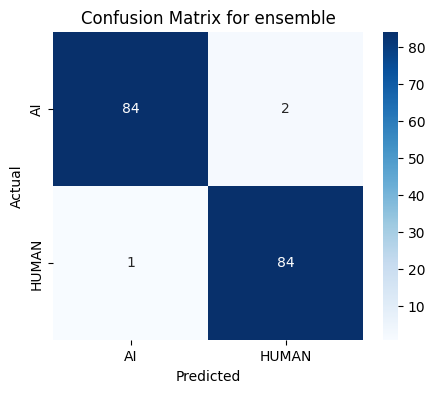

In [5]:
# ensemble method
# Load the models

model_mt5 = load_model('/kaggle/working/Tamil/MT5_dnn_model.h5')
model_roberta = load_model('/kaggle/working/Tamil/XLM_dnn_model.h5')
model_indic = load_model('/kaggle/working/Tamil/indic_dnn_model.h5')
model_sentence = load_model('/kaggle/working/Tamil/sentence_dnn_model.h5')

# Load the scalers
scaler_mt5 = joblib.load('/kaggle/working/Tamil/MT5_scaler.pkl')
scaler_roberta = joblib.load('/kaggle/working/Tamil/XLM_scaler.pkl')
scaler_indic = joblib.load('/kaggle/working/Tamil/indic_scaler.pkl')
scaler_sentence = joblib.load('/kaggle/working/Tamil/sentence_scaler.pkl')

# Load the label encoders
label_encoder = joblib.load('/kaggle/working/Tamil/label_encoder.pkl')

##################################################################
X_mt5 = X_weights[0]
X_roberta = X_weights[1]
X_indic = X_weights[2]
X_sentence = X_weights[3]

# Generate all possible weight combinations that sum to 1
def generate_weights(step=0.1):
    weights = []
    for w in product(np.arange(0, 1 + step, step), repeat=4):
        if np.isclose(sum(w), 1):  # Ensure weights sum to 1
            weights.append(w)
    return weights

# Perform grid search to find the best weights
def grid_search_weights(X_mt5, X_roberta, X_indic, X_sentence, y_true, step=0.1):
    weights_list = generate_weights(step=step)
    best_weights = None
    best_accuracy = 0

    for weights in weights_list:
        predictions = ensemble_predict_weights(X_mt5, X_roberta, X_indic, X_sentence, weights)
        accuracy = accuracy_score(y_true, predictions)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = weights

    return best_weights, best_accuracy

y_weights = np.concatenate((y_train, y_val),axis=0)
# Example usage
weights_list = generate_weights(step=0.1)
best_weights, best_accuracy = grid_search_weights(X_mt5, X_roberta, X_indic, X_sentence, y_weights)

print("Best Weights:", best_weights)
print("Best Accuracy:", best_accuracy)

##############################################################################################
X_mt5 = test[0]
X_roberta = test[1]
X_indic = test[2]
X_sentence = test[3]

opt_weights = best_weights

ensemble_predictions = ensemble_predict_weights(X_mt5, X_roberta, X_indic, X_sentence, opt_weights)
accuracy = accuracy_score(y_test, ensemble_predictions)

print("\nAccuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, ensemble_predictions))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for ensemble')
plt.show()

## Predict for test data - Tamil

In [7]:
test_data = pd.read_csv('/kaggle/input/naacl-human-ai-features-embeddings/MT5/tam_test_data_hum_ai_mt5_embeddings.csv')
language = 'Tamil'

# label_encoder = LabelEncoder()
# label_encoder.fit(data_sentence['LABEL'])

test_ID = test_data['ID']

paths =['/kaggle/input/naacl-human-ai-features-embeddings/MT5/tam_test_data_hum_ai_mt5_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/XLM/tam_test_data_hum_ai_roberta_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/indic/tam_test_data_hum_ai_indicbert_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/sentence/tam_test_data_hum_ai_sentence_embeddings.csv']

In [8]:
test = []
for index, path in enumerate(paths):
    name = path.split('/')[-2]
    data_sentence = pd.read_csv(path)
    test_data_sentence = data_sentence[data_sentence['ID'].isin(test_ID)]
    test_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)

    X_test = test_data_sentence

    if name == 'MT5':
        scaler = scaler_mt5
    elif name == 'XLM':
        scaler = scaler_roberta
    elif name == 'indic':
        scaler = scaler_indic
    else:
        scaler = scaler_sentence

    X_test = scaler.transform(X_test)
    test.append(X_test)

In [9]:
model_mt5 = load_model('/kaggle/working/Tamil/MT5_dnn_model.h5')
model_roberta = load_model('/kaggle/working/Tamil/XLM_dnn_model.h5')
model_indic = load_model('/kaggle/working/Tamil/indic_dnn_model.h5')
model_sentence = load_model('/kaggle/working/Tamil/sentence_dnn_model.h5')

# Load the scalers
scaler_mt5 = joblib.load('/kaggle/working/Tamil/MT5_scaler.pkl')
scaler_roberta = joblib.load('/kaggle/working/Tamil/XLM_scaler.pkl')
scaler_indic = joblib.load('/kaggle/working/Tamil/indic_scaler.pkl')
scaler_sentence = joblib.load('/kaggle/working/Tamil/sentence_scaler.pkl')

# Load the label encoders
label_encoder = joblib.load('/kaggle/working/Tamil/label_encoder.pkl')

X_mt5 = test[0]
X_roberta = test[1]
X_indic = test[2]
X_sentence = test[3]

opt_weights = best_weights  # (0.0, 0.1, 0.5, 0.4)

ensemble_predictions = ensemble_predict_weights(X_mt5, X_roberta, X_indic, X_sentence, opt_weights)

test_tsv = pd.DataFrame({'ID': test_ID, 'DATA':test_data['DATA'] , 'LABEL': label_encoder.inverse_transform(ensemble_predictions)})
test_tsv.sample(10)

,ID,DATA,LABEL
83,TAM_HUAI_TE_084,புகைப்படம் எடுக்க நல்லா இருக்கும்,HUMAN
53,TAM_HUAI_TE_054,என் பைக்/வாகனப் பிராண்ட் மிகவும் நம்பகமானது மற...,HUMAN
70,TAM_HUAI_TE_071,தோல் ரொம்ப வறண்டு விட்டது,HUMAN
45,TAM_HUAI_TE_046,"என் சோப்/பாடி வாஷ் பயன்படுத்தினால, தோலின் உலர்...",AI
44,TAM_HUAI_TE_045,என் சோப்/பாடி வாஷ் உலர்ந்த தோற்றத்தை சீராக துட...,HUMAN
39,TAM_HUAI_TE_040,"என் கடிகார பிராண்ட் மிகவும் ஸ்டைலிஷாகவும், நம்...",HUMAN
22,TAM_HUAI_TE_023,இந்த முகம் கழுவி என் முகத்தை வறண்டு போகச் செய்...,AI
80,TAM_HUAI_TE_081,நினைவக சேமிப்பு குறைவா இருக்கு,HUMAN
10,TAM_HUAI_TE_011,இந்த காலணி தரம் குறைவாக உள்ளது. ஒரு வாரத்திற்க...,AI
0,TAM_HUAI_TE_001,நான் அண்மையில் வாங்கிய ஒரு வாட்டர் பாட்டில் ம...,HUMAN


In [10]:
test_tsv.to_csv(f'{language}_ensemble_predictions.tsv', sep='\t', index=False)

## Malayalam

In [11]:
data_sentence = pd.read_csv('/kaggle/input/naacl-human-ai-features-embeddings/MT5/mal_training_data_hum_ai_mt5_embeddings.csv')
language = 'Malayalam'

label_encoder = LabelEncoder()
label_encoder.fit(data_sentence['LABEL'])

# split the data_sentence into train, validation and test
train_df, test_df = train_test_split(data_sentence, test_size=trn_test_split, stratify=data_sentence['LABEL'], shuffle=True, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=val_test_split, stratify=test_df['LABEL'], shuffle=True, random_state=42)

train_ID = train_df['ID']
val_ID = val_df['ID']
test_ID = test_df['ID']

paths =['/kaggle/input/naacl-human-ai-features-embeddings/MT5/mal_training_data_hum_ai_mt5_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/XLM/mal_training_data_hum_ai_roberta_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/indic/mal_training_data_hum_ai_indicbert_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/sentence/mal_training_data_hum_ai_sentence_embeddings.csv']

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 810,398 (3.09 MB)

 Trainable params: 807,838 (3.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

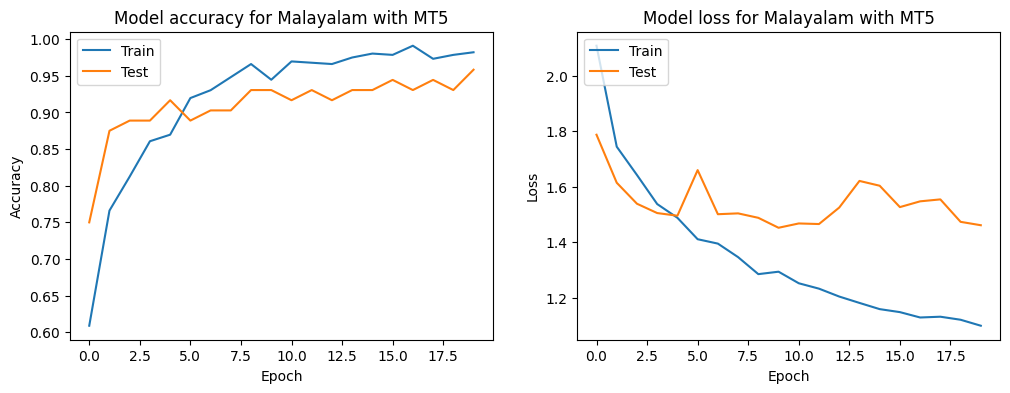

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
For Malayalam with MT5:
Accuracy: 0.9642857142857143

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        84
           1       0.99      0.94      0.96        84

    accuracy                           0.96       168
   macro avg       0.97      0.96      0.96       168
weighted avg       0.97      0.96      0.96       168



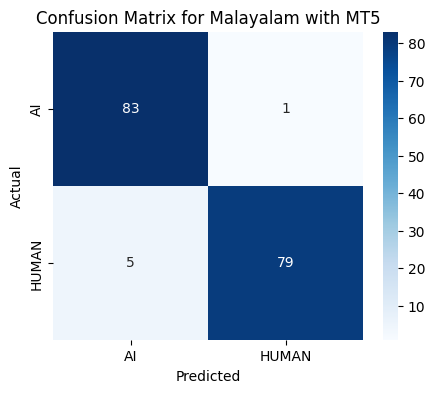

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 1024)                │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,542 (4.09 MB)

 Trainable params: 1,069,982 (4.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

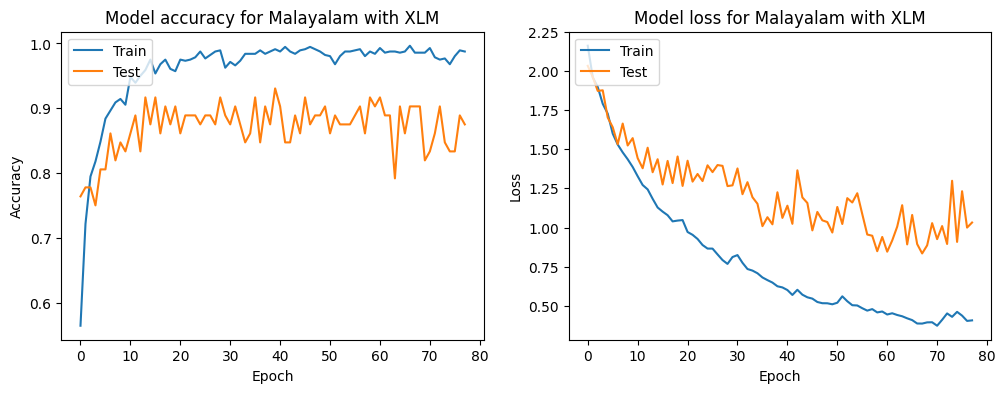

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
For Malayalam with XLM:
Accuracy: 0.9642857142857143

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        84
           1       0.99      0.94      0.96        84

    accuracy                           0.96       168
   macro avg       0.97      0.96      0.96       168
weighted avg       0.97      0.96      0.96       168



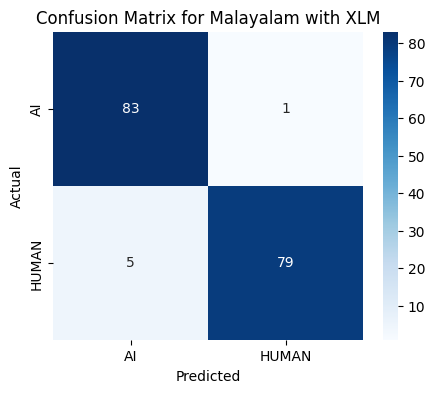

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                     │ (None, 1024)                │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,542 (4.09 MB)

 Trainable params: 1,069,982 (4.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

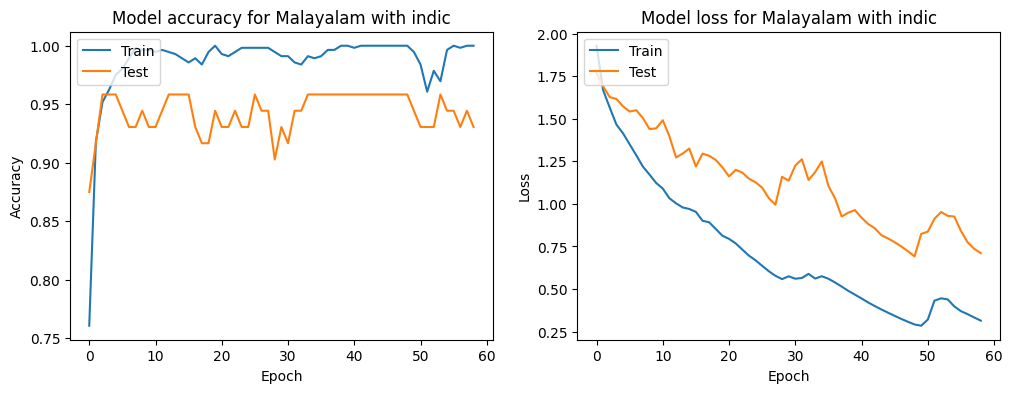

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
For Malayalam with indic:
Accuracy: 0.9345238095238095

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        84
           1       0.97      0.89      0.93        84

    accuracy                           0.93       168
   macro avg       0.94      0.93      0.93       168
weighted avg       0.94      0.93      0.93       168



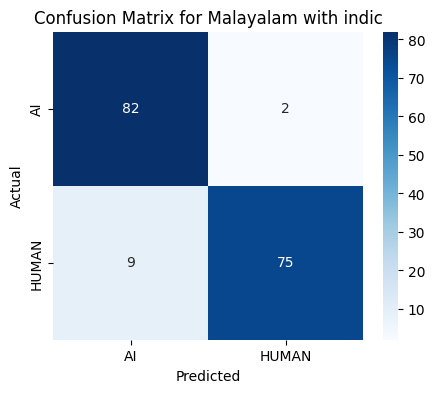

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 810,398 (3.09 MB)

 Trainable params: 807,838 (3.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

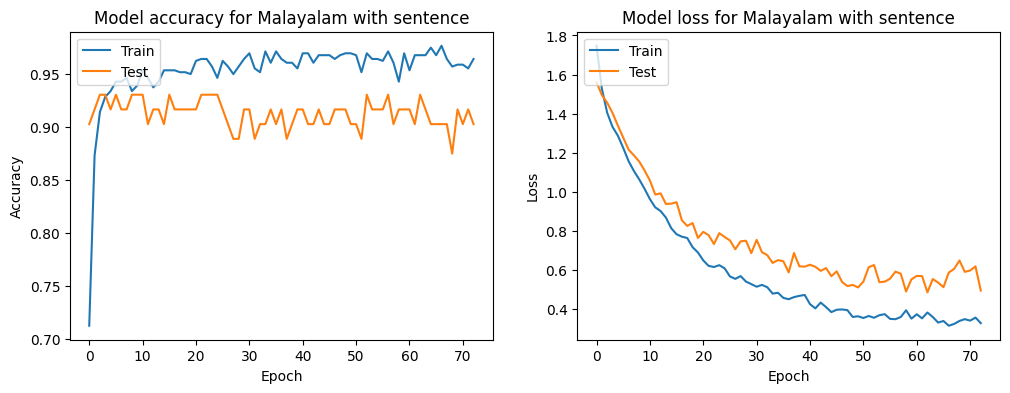

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
For Malayalam with sentence:
Accuracy: 0.9047619047619048

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        84
           1       0.90      0.90      0.90        84

    accuracy                           0.90       168
   macro avg       0.90      0.90      0.90       168
weighted avg       0.90      0.90      0.90       168



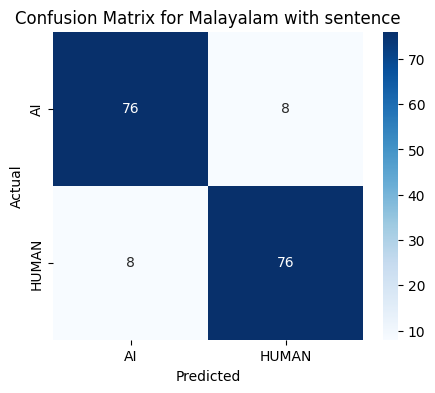

In [12]:
test = []
X_weights = []

for index, path in enumerate(paths):
    name = path.split('/')[-2]
    data_sentence = pd.read_csv(path)
    train_data_sentence = data_sentence[data_sentence['ID'].isin(train_ID)]
    val_data_sentence = data_sentence[data_sentence['ID'].isin(val_ID)]
    test_data_sentence = data_sentence[data_sentence['ID'].isin(test_ID)]
    train_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)
    val_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)
    test_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)

    input_shape = (train_data_sentence.shape[1] - 1,)
    num_classes = 2

    # Specify the learning rate
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)

    model = create_dnn_model(input_shape, num_classes)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Display the model's architecture
    model.summary()

    X_train = train_data_sentence.drop(columns=['LABEL'], axis=1)
    y_train = train_data_sentence['LABEL']

    X_val = val_data_sentence.drop(columns=['LABEL'], axis=1)
    y_val = val_data_sentence['LABEL']

    X_test = test_data_sentence.drop(columns=['LABEL'], axis=1)
    y_test = test_data_sentence['LABEL']

    y_train = label_encoder.transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Define a learning rate reduction callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model_checkpoint = ModelCheckpoint(f'{language}/{name}_best_model.weights.h5', save_best_only=True, save_weights_only=True, verbose=0, monitor='val_loss', mode='min')

    # Train the model with the learning rate reducer and early stopping callbacks
    history = model.fit(X_train, y_train,
                        epochs=250,
                        validation_data=(X_val, y_val),
                        verbose=0,
                        callbacks=[reduce_lr, early_stopping, model_checkpoint])

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy for {language} with {name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss for {language} with {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'For {language} with {name}:')
    print("Accuracy:", accuracy)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {language} with {name}')
    plt.show()

    # Save the model
    model.save(f'{language}/{name}_dnn_model.h5')

    # Save the scaler
    joblib.dump(scaler, f'{language}/{name}_scaler.pkl')

    # Save the label encoder
    joblib.dump(label_encoder, f'{language}/label_encoder.pkl')

    # Save the model architecture as JSON
    model_json = model.to_json()
    with open('dnn_model.json', 'w') as json_file:
        json_file.write(model_json)

    test.append(X_test)
    X_weights.append(np.concatenate((X_train, X_val), axis=0))

### Ensemble Malayalam

Best Weights: (0.1, 0.4, 0.4, 0.1)
Best Accuracy: 0.995253164556962

Accuracy: 0.9404761904761905
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        84
           1       0.99      0.89      0.94        84

    accuracy                           0.94       168
   macro avg       0.94      0.94      0.94       168
weighted avg       0.94      0.94      0.94       168



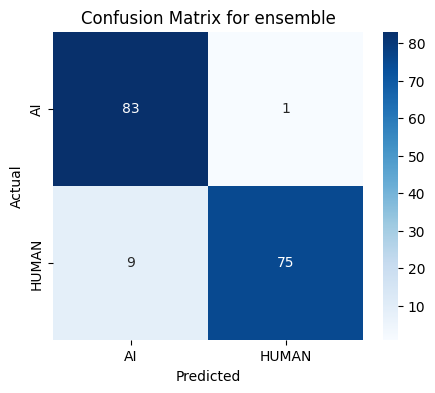

In [13]:
# ensemble method
# Load the models
model_mt5 = load_model('/kaggle/working/Malayalam/MT5_dnn_model.h5')
model_roberta = load_model('/kaggle/working/Malayalam/XLM_dnn_model.h5')
model_indic = load_model('/kaggle/working/Malayalam/indic_dnn_model.h5')
model_sentence = load_model('/kaggle/working/Malayalam/sentence_dnn_model.h5')

# Load the scalers
scaler_mt5 = joblib.load('/kaggle/working/Malayalam/MT5_scaler.pkl')
scaler_roberta = joblib.load('/kaggle/working/Malayalam/XLM_scaler.pkl')
scaler_indic = joblib.load('/kaggle/working/Malayalam/indic_scaler.pkl')
scaler_sentence = joblib.load('/kaggle/working/Malayalam/sentence_scaler.pkl')

# Load the label encoders
label_encoder = joblib.load('/kaggle/working/Malayalam/label_encoder.pkl')

##################################################################
X_mt5 = X_weights[0]
X_roberta = X_weights[1]
X_indic = X_weights[2]
X_sentence = X_weights[3]

# Generate all possible weight combinations that sum to 1
def generate_weights(step=0.1):
    weights = []
    for w in product(np.arange(0, 1 + step, step), repeat=4):
        if np.isclose(sum(w), 1):  # Ensure weights sum to 1
            weights.append(w)
    return weights

# Perform grid search to find the best weights
def grid_search_weights(X_mt5, X_roberta, X_indic, X_sentence, y_true, step=0.1):
    weights_list = generate_weights(step=step)
    best_weights = None
    best_accuracy = 0

    for weights in weights_list:
        predictions = ensemble_predict_weights(X_mt5, X_roberta, X_indic, X_sentence, weights)
        accuracy = accuracy_score(y_true, predictions)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = weights

    return best_weights, best_accuracy

y_weights = np.concatenate((y_train, y_val),axis=0)
# Example usage
weights_list = generate_weights(step=0.1)
best_weights, best_accuracy = grid_search_weights(X_mt5, X_roberta, X_indic, X_sentence, y_weights)

print("Best Weights:", best_weights)
print("Best Accuracy:", best_accuracy)

##############################################################################################
X_mt5 = test[0]
X_roberta = test[1]
X_indic = test[2]
X_sentence = test[3]

opt_weights = best_weights

ensemble_predictions = ensemble_predict_weights(X_mt5, X_roberta, X_indic, X_sentence, opt_weights)
accuracy = accuracy_score(y_test, ensemble_predictions)

print("\nAccuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, ensemble_predictions))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for ensemble')
plt.show()

## Predict for test data - Malayalam

In [14]:
test_data = pd.read_csv('/kaggle/input/naacl-human-ai-features-embeddings/MT5/mal_test_data_hum_ai_mt5_embeddings.csv')
language = 'Malayalam'

test_ID = test_data['ID']

paths =['/kaggle/input/naacl-human-ai-features-embeddings/MT5/mal_test_data_hum_ai_mt5_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/XLM/mal_test_data_hum_ai_roberta_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/indic/mal_test_data_hum_ai_indicbert_embeddings.csv',
        '/kaggle/input/naacl-human-ai-features-embeddings/sentence/mal_test_data_hum_ai_sentence_embeddings.csv']

In [15]:
test = []
for index, path in enumerate(paths):
    name = path.split('/')[-2]
    data_sentence = pd.read_csv(path)
    test_data_sentence = data_sentence[data_sentence['ID'].isin(test_ID)]
    test_data_sentence.drop(columns=['DATA', 'preprocessed_data','ID'], inplace=True,  axis=1)

    X_test = test_data_sentence

    if name == 'MT5':
        scaler = scaler_mt5
    elif name == 'XLM':
        scaler = scaler_roberta
    elif name == 'indic':
        scaler = scaler_indic
    else:
        scaler = scaler_sentence

    X_test = scaler.transform(X_test)
    test.append(X_test)

In [16]:
# ensemble method
# Load the models
model_mt5 = load_model('/kaggle/working/Malayalam/MT5_dnn_model.h5')
model_roberta = load_model('/kaggle/working/Malayalam/XLM_dnn_model.h5')
model_indic = load_model('/kaggle/working/Malayalam/indic_dnn_model.h5')
model_sentence = load_model('/kaggle/working/Malayalam/sentence_dnn_model.h5')

# Load the scalers
scaler_mt5 = joblib.load('/kaggle/working/Malayalam/MT5_scaler.pkl')
scaler_roberta = joblib.load('/kaggle/working/Malayalam/XLM_scaler.pkl')
scaler_indic = joblib.load('/kaggle/working/Malayalam/indic_scaler.pkl')
scaler_sentence = joblib.load('/kaggle/working/Malayalam/sentence_scaler.pkl')

# Load the label encoders
label_encoder = joblib.load('/kaggle/working/Malayalam/label_encoder.pkl')

X_mt5 = test[0]
X_roberta = test[1]
X_indic = test[2]
X_sentence = test[3]

opt_weights = best_weights 

ensemble_predictions = ensemble_predict_weights(X_mt5, X_roberta, X_indic, X_sentence, opt_weights)

test_tsv = pd.DataFrame({'ID': test_ID, 'DATA':test_data['DATA'] , 'LABEL': label_encoder.inverse_transform(ensemble_predictions)})
test_tsv.sample(10)

,ID,DATA,LABEL
169,MAL_HUAI_TE_170,നമുക്ക് കൂടി ലഭിക്കുന്ന ഇഎംഐക്ക് ഒരുപാട് മോഡലു...,HUMAN
46,MAL_HUAI_TE_047,ഇന്റീരിയർ കളർ കുറച്ച് കൂടെ ചോക്ലേറ്റ് ബ്രൗൺ ആയ...,HUMAN
101,MAL_HUAI_TE_102,കോവയ്ക്ക ഉപ്പിലിട്ടത് ഞാൻ ഇതുവരെ കഴിച്ചിട്ടില്...,AI
164,MAL_HUAI_TE_165,റോയൽ എൻഫീൽഡ് സീരിയസ് ആയി 800 സിസി ബൈക്ക് ഇറക്ക...,HUMAN
157,MAL_HUAI_TE_158,പുറകിൽ ഒരു 140 എംഎം വീൽ കൊടുത്താലും റിയർ ബേലൻസ...,AI
155,MAL_HUAI_TE_156,വണ്ടിയുടെ ടോർക്ക് അടിപൊളിയാണെങ്കിലും സീറ്റ് കം...,AI
106,MAL_HUAI_TE_107,"പല തട്ടുകടകളിലെ കറികൾ വെള്ളം പോലെ ഉണ്ട്, കഴിക്...",AI
90,MAL_HUAI_TE_091,ക്രെഡിറ്റ് കാർഡ് ഉള്ളത് കൊണ്ടാണ് വേറെ ആരുടെ കയ...,HUMAN
9,MAL_HUAI_TE_010,ബെസ്റ് .ആദ്യമേ തന്നെ ചിക്കെൻ പീസ് വറുത്ത് ഗ്ലോ...,HUMAN
63,MAL_HUAI_TE_064,പുതിയ എൻ.എസ് 400ന് ഈ ഡിസൈൻ കൊടുത്ത് റിയർ വീൽ ...,HUMAN


In [17]:
test_tsv.to_csv(f'{language}_ensemble_predictions.tsv', sep='\t', index=False)